# Análise de Dados de Cartão de Crédito de Clientes de um Banco

# Introdução

Um gerente de banco está preocupado porque cada vez mais clientes estão abandonando os serviços de cartão de crédito.

Este caderno irá prever quem tem maior probabilidade de ser rejeitado entre os clientes do banco; dessa forma, o banco agirá de acordo para resolver o problema real.

# 1. Importando bibliotecas

In [1]:
import proplot
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as mtick
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

print(">>> Bibliotecas importadas com sucesso.")

>>> Bibliotecas importadas com sucesso.


# 2. Carregamento e Leitura dos Dados

In [2]:
data = pd.read_csv("/projeto/4eb891ca-56f7-4483-ab9d-38183df56ec3/workdir/MinhasCoisas/BankChurners.csv")

data = data.iloc[:, :-2]

client_num = data['CLIENTNUM']
del data['CLIENTNUM']

print(">>> Dados carregados com sucesso.")

>>> Dados carregados com sucesso.


In [3]:
print(">>> Amostra de dados.")

data.head(5)

>>> Amostra de dados.


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## 2.1 Verificando Type, Null's e Medidas Descritivas.

**Análise Descritiva:**

- Analisar as categorias dos dados de cada variável.
- Reconhecer números faltantes e conflitantes.
- Apresentar as estatísticas de  tendência central, dispersão e assimetria para variáveis numéricas.
- Analisar a distribuição de frequência de cada tipo em variáveis categóricas.

In [4]:
print(">>> Types\n", data.dtypes)

print("\n>>> Null's\n", data.isnull().sum())

print("\n>>> Medidas descritivas para variáveis numéricas\n", data.describe())

print("\n>>> Forma dos Dados\n", data.shape)

print("\n>>> Número de Linhas Duplicadas\n", len(data[data.duplicated()]))

>>> Types
 Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

>>> Null's
 Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Mo

## 2.2 Análise Exploratoria

Em seguida, os dados são  inspecionados e analisados visualmente para compreender suas principais características.

Automatizar essas tarefas torna o processo de visualização de dados mais fácil e rápido, economizando tempo e esforço.
A função plot_design é definida para padronizar a estética do gráfico personalizando rótulos, títulos, layout e outros elementos visuais.

O loop percorre todas as colunas categóricas e numéricas no DataFrame, cria gráficos de barras para colunas categóricas e histogramas para colunas numéricas e aplica uma função de design para garantir consistência visual.
Isso permite que você analise visualmente de forma sistemática e eficaz as principais características do seu conjunto de dados, ajudando a identificar padrões e insights importantes.



In [5]:
def plot_design():
    plt.xlabel("")
    plt.ylabel("")
    plt.yticks(fontsize=13, color="black")
    plt.box(False)
    plt.title(i[1], fontsize=20, color="black")
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

print(">>> Função de design de gráficos criada com sucesso.")

>>> Função de design de gráficos criada com sucesso.


### 2.2.1 Variáveis Categóricas

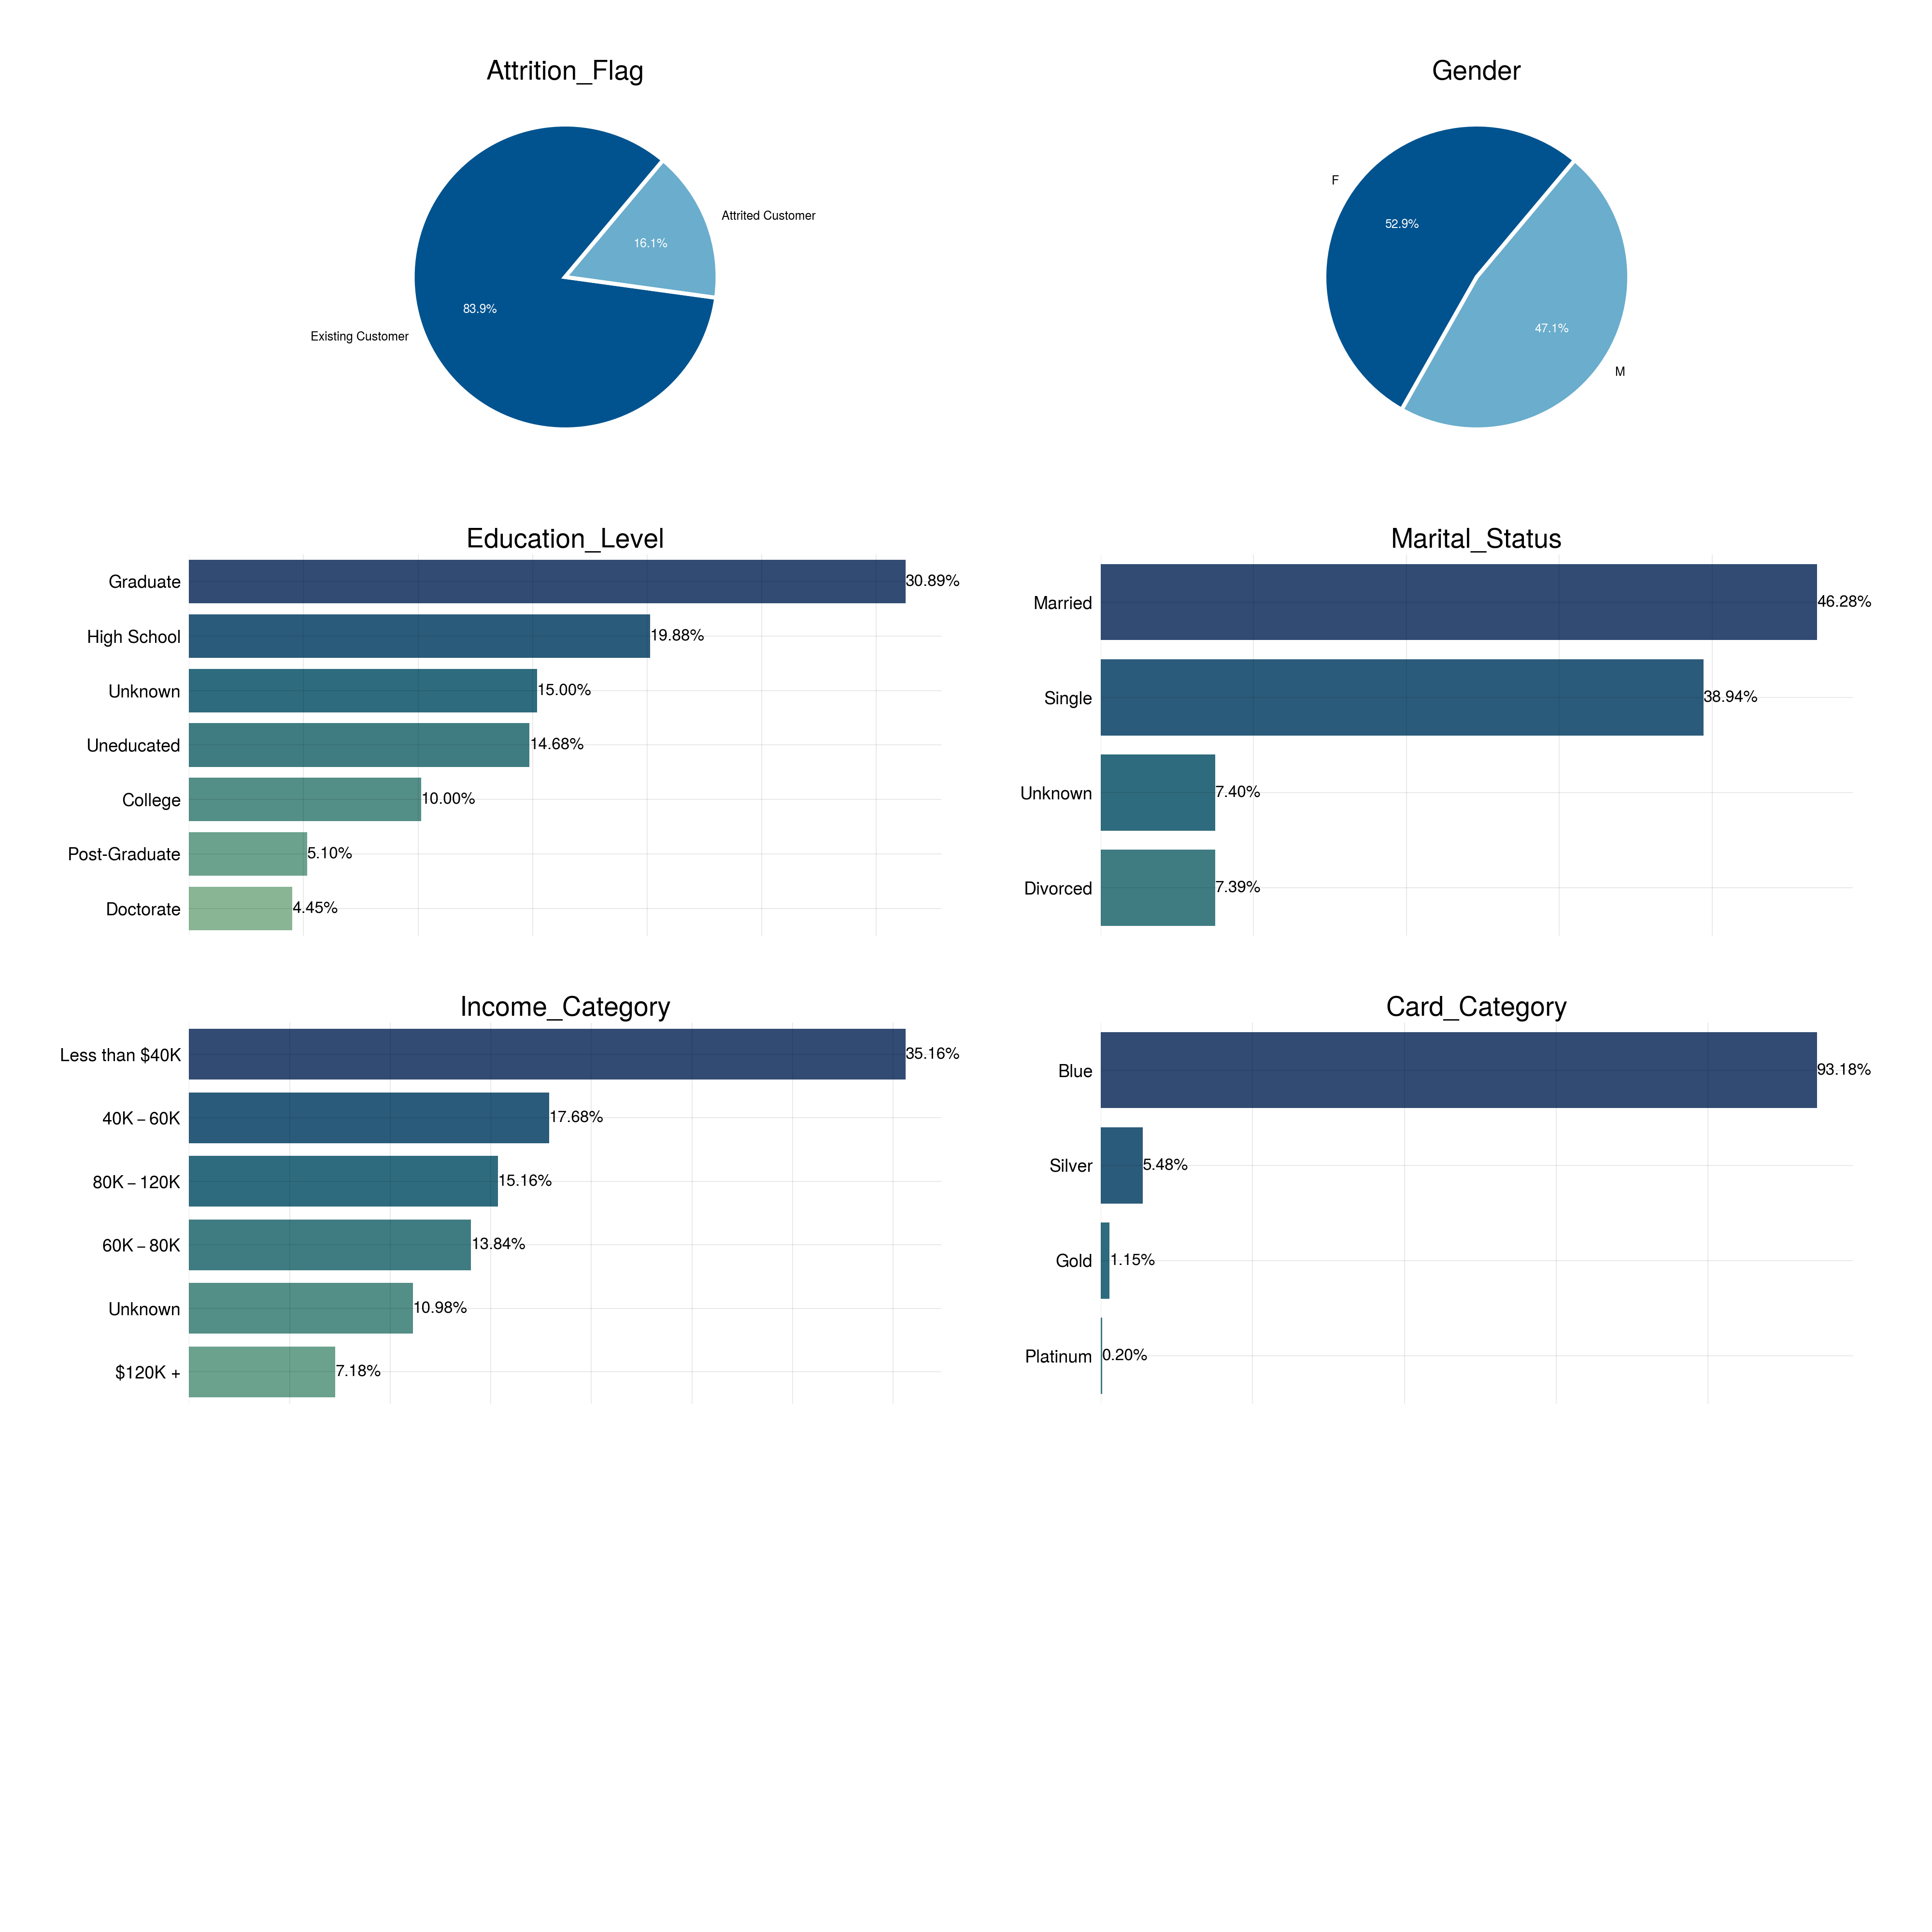

In [6]:
categ = data.select_dtypes(include=object).columns

fig, ax = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor("white")

paleta = sns.color_palette("crest_r", n_colors=7).as_hex()

for i in enumerate(categ):
    plt.subplot(4, 2, i[0] + 1)

    if data[i[1]].value_counts().count() > 2:
        ax = sns.countplot(
            y=i[1], data=data, order=data[i[1]].value_counts().index, palette=paleta
        )
        pct = data[i[1]].value_counts(ascending=False, normalize=True).values * 100
        for container in ax.containers:
            labels = list(map("{:.2f}%".format, pct))
            for bar, label in zip(container, labels):
                ax.text(
                    bar.get_width() + 0.05, 
                    bar.get_y() + bar.get_height() / 2, 
                    label, 
                    va='center', 
                    ha='left', 
                    fontsize=12, 
                    color='black'
                )
        ax.grid(False)
        ax.xaxis.set_ticks_position("none")
        ax.yaxis.set_ticks_position("none")
        ax.set_xticklabels([])
        plot_design()
    else:
        _, texts, pcts = plt.pie(
            data[i[1]].value_counts(),
            labels=data[i[1]].value_counts().index,
            colors=["#00538F", "#6AADCC"],
            autopct="%1.1f%%",
            wedgeprops={"linewidth": 3.0, "edgecolor": "white"},
            startangle=50,
        )
        for pct in pcts:
            pct.set_color("white")
        plt.title(i[1], fontsize=20, color="black")

plt.show()

Aqui é importante notar que a variável alvo **(Attrition_Flag)** está desbalanceada.

Para lidar com dados desbalanceados, iremos explorar o **algoritmo SMOTE** para aumentar a amostragem dos dados e obter um equilíbrio entre as classes.

### 2.2.2 Variáveis Numéricas

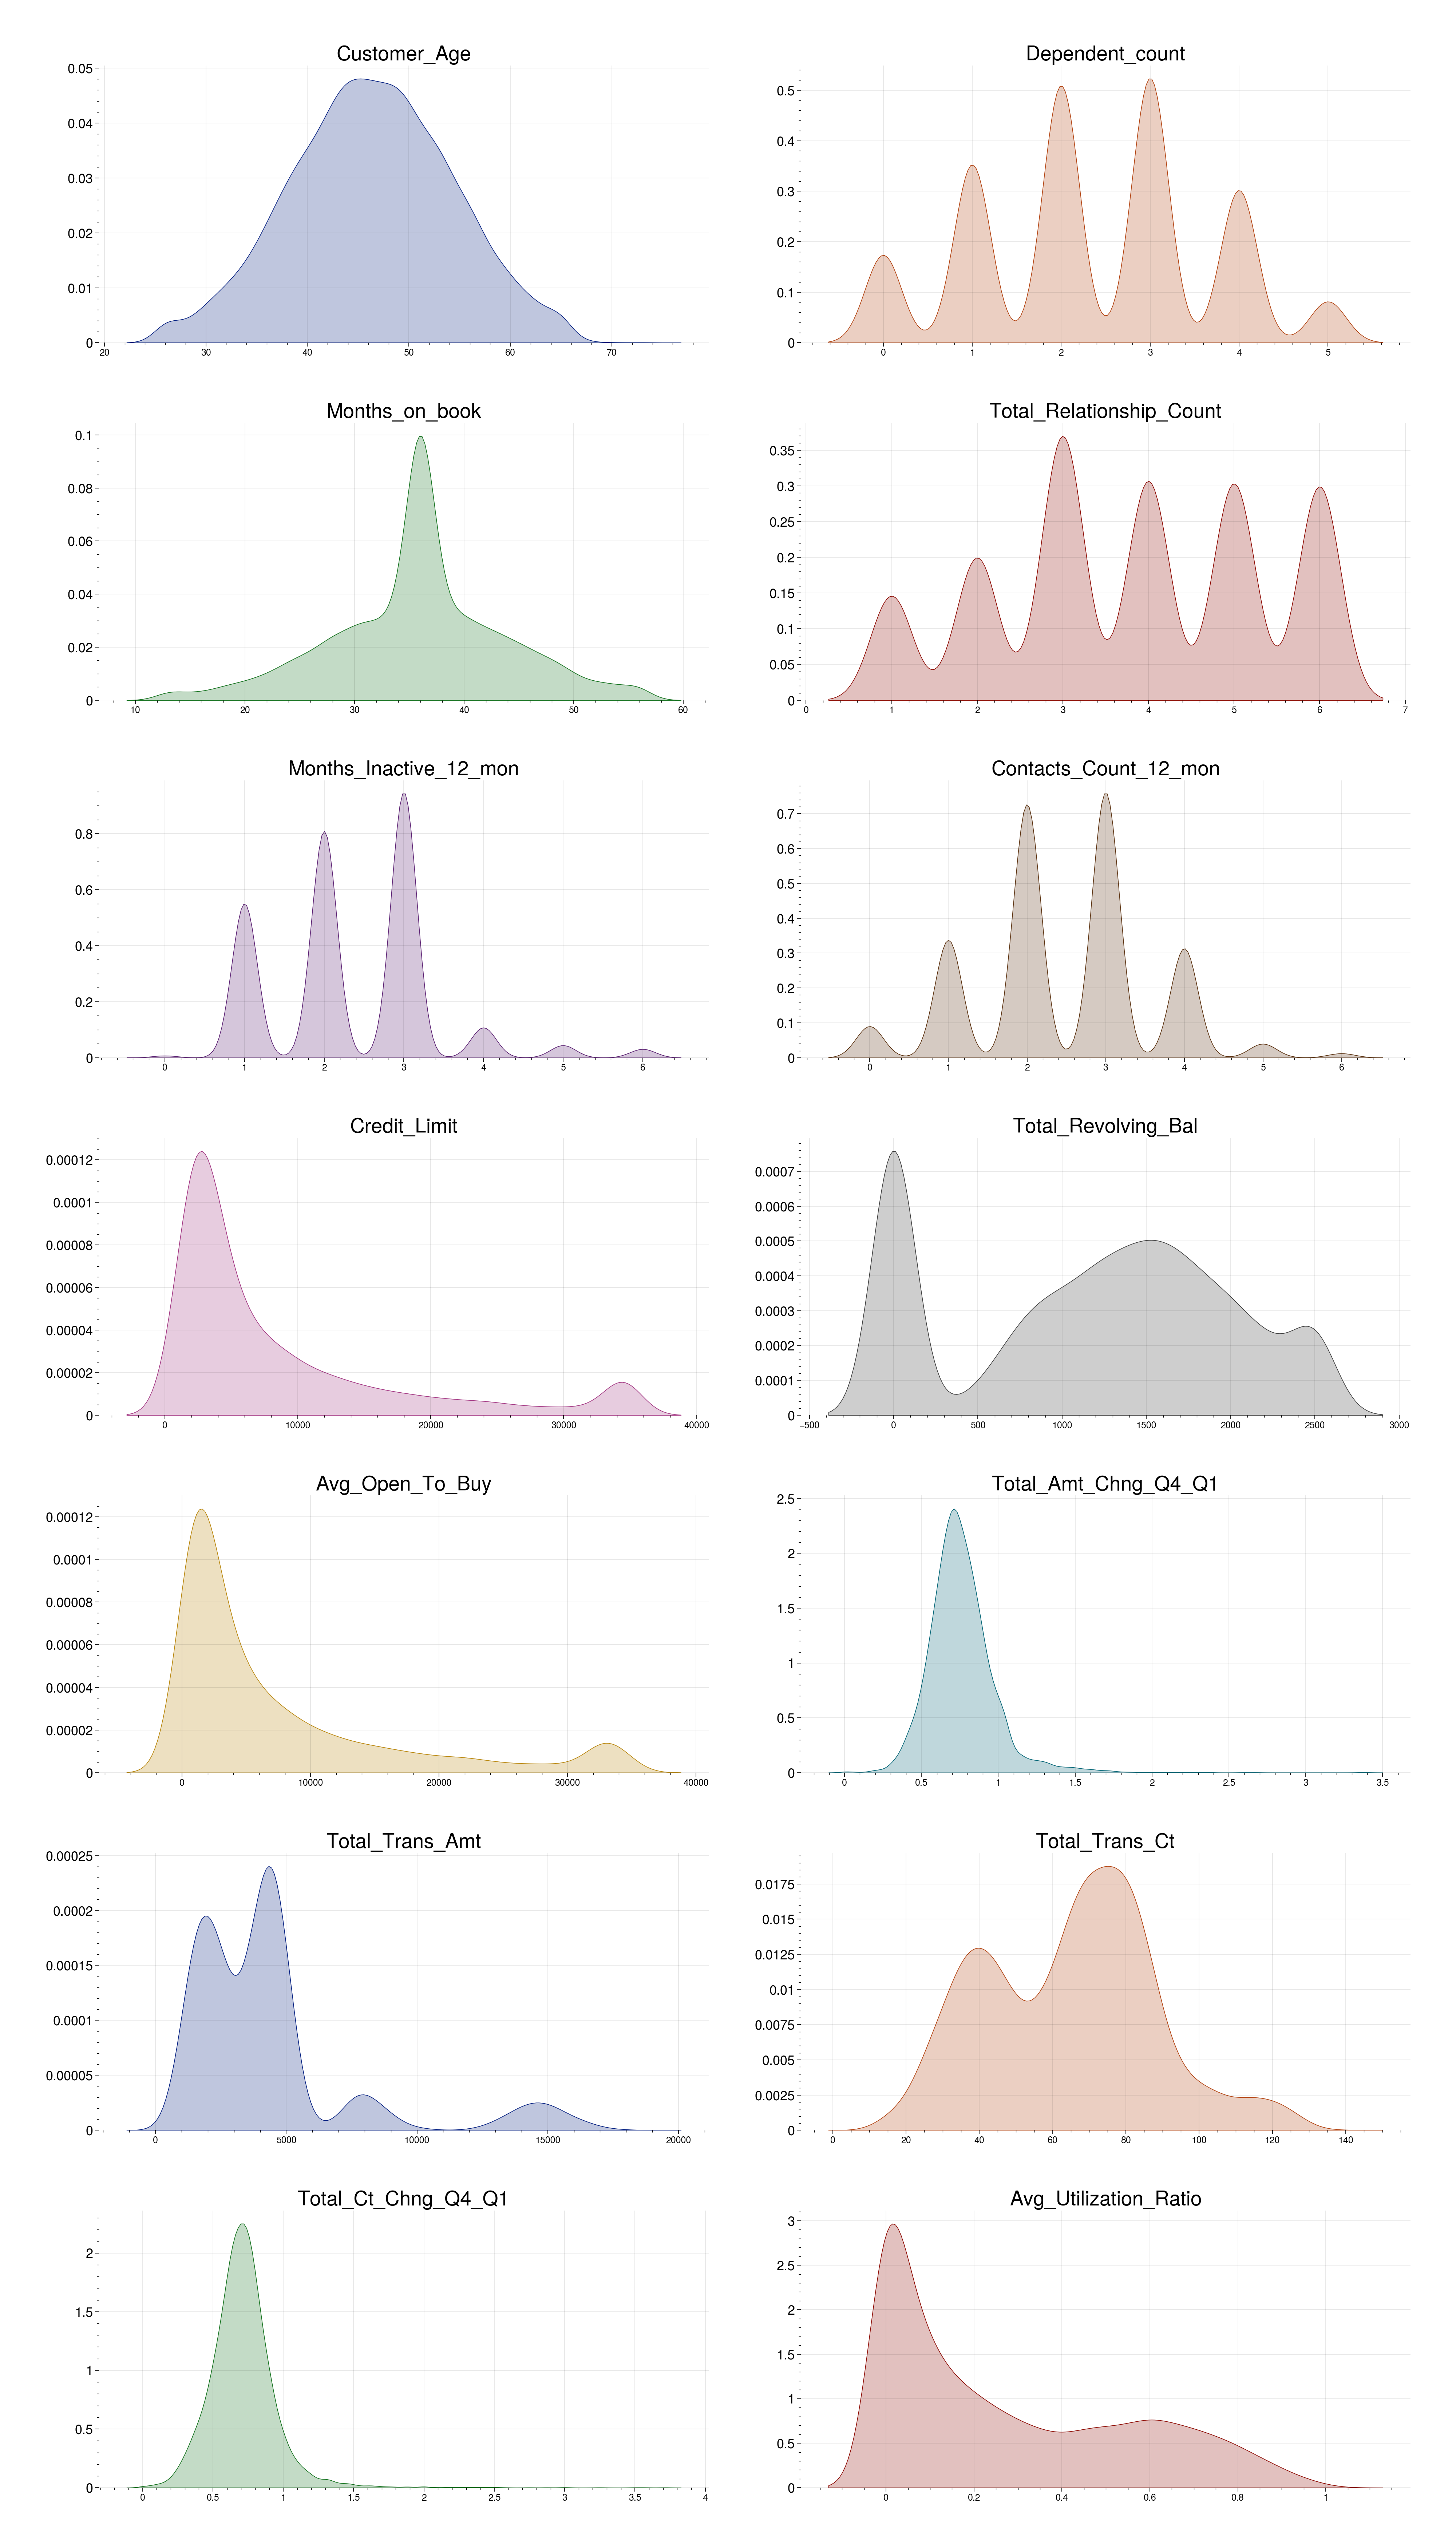

In [7]:
numericas = data.select_dtypes(exclude=object).columns

fig, ax = plt.subplots(figsize =(20, 35))
fig.patch.set_facecolor('white')

paleta = sns.color_palette("dark", n_colors=14).as_hex()

for i in (enumerate(numericas)):
    plt.subplot(7, 2, i[0]+1)
    sns.kdeplot(x = i[1], data = data, color=paleta[i[0]], fill=True)
    plt.grid(b=None)
    plot_design()


# 3. Preprocessamento de Dados

## 3.1 Distribuições Assimétricas

"Skew Features" referem-se a variáveis em um conjunto de dados que apresentam uma distribuição assimétrica. Em outras palavras, a distribuição dos valores dessas variáveis não é simétrica em torno da média.

In [8]:
skew_limit = 0.5
skew_vals = data[numericas].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

,Skew
Total_Ct_Chng_Q4_Q1,2.064031
Total_Trans_Amt,2.041003
Total_Amt_Chng_Q4_Q1,1.732063
Credit_Limit,1.666726
Avg_Open_To_Buy,1.661697
Avg_Utilization_Ratio,0.718008
Months_Inactive_12_mon,0.633061


Na nossa situação, optaremos por aplicar a transformação Box-Cox para normalizar todas as características que apresentam assimetria em direção a uma distribuição normal.


In [9]:
for col in skew_cols.index:
    if data[col].nunique() > 1:
        data[col] = boxcox1p(data[col], boxcox_normmax(data[col] + 1))
    else:
        print(f"Coluna {col} é constante e não será transformada.")

print(">>> Box-Cox aplicado com sucesso.")

/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


>>> Box-Cox aplicado com sucesso.


## 3.2 Recursos de Scaling

Um procedimento que é utilizado para adaptar as características dos dados para uma escala específica, assegurando que todas tenham uma influência uniforme na análise. Isso é particularmente crucial para evitar distorções nos cálculos de distância entre pontos ou nos gradientes para otimização, como no algoritmo de aprendizado de máquina que está sendo desenvolvido e será aplicado posteriormente.

In [10]:
for col in data[numericas]:
    data[col] = MinMaxScaler().fit_transform(data[[col]])
    
print(">>> Função MinMaxScaler aplicada com sucesso.")

>>> Função MinMaxScaler aplicada com sucesso.


## 3.3 One-Hot Encoding de Campos Categóricos

O One-Hot Encoding é usado para reduzir a dimensionalidade de variáveis categóricas codificadas one-hot e perder parte da variação, mas em vez de dezenas de recursos codificados one-hot, vários componentes principais são analisados simultaneamente.

As variáveis utilizadas para o processo One-hot Encoding serão apenas as qualitativas nominais.

In [11]:
data["Attrition_Flag"] = data["Attrition_Flag"].map(
    {"Existing Customer": 0, "Attrited Customer": 1}
)
data["Gender"] = data["Gender"].map({"M": 0, "F": 1})

categ = data.select_dtypes(include=object).columns

data = pd.get_dummies(data, columns=categ)

data = data[data.columns.drop(list(data.filter(regex="Unknown")))]
data = data[data.columns.drop(list(data.filter(regex="Platinum")))]

data.head(5)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,...,Marital_Status_Married,Marital_Status_Single,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Silver
0,0,0.404255,0,0.6,0.604651,0.8,0.262481,0.500000,0.795967,0.308701,...,1,0,0,0,1,0,0,1,0,0
1,0,0.489362,1,1.0,0.720930,1.0,0.262481,0.333333,0.683417,0.343266,...,0,1,0,0,0,0,1,1,0,0
2,0,0.531915,0,0.6,0.534884,0.6,0.262481,0.000000,0.391116,0.000000,...,1,0,0,0,0,1,0,1,0,0
3,0,0.297872,1,0.8,0.488372,0.4,0.760075,0.166667,0.379005,1.000000,...,0,0,0,0,0,0,1,1,0,0
4,0,0.297872,0,0.6,0.186047,0.8,0.262481,0.000000,0.508545,0.000000,...,1,0,0,0,1,0,0,1,0,0


## 3.4 Upsampling de Dados Usando Algoritmo SMOTE

'SMOTE' (Synthetic Minority Over-sampling Technique) é uma técnica usada para lidar com conjuntos de dados desbalanceados em problemas de aprendizado de máquina. 

As novas instâncias não são meras cópias dos casos minoritários existentes; em vez disso, o algoritmo amostra o espaço de características para cada classe alvo e seus vizinhos mais próximos, gerando novos exemplos que combinam características do caso alvo com características de seus vizinhos. Essa abordagem aumenta os recursos disponíveis para cada classe e torna as amostras mais representativas.

O SMOTE considera o conjunto de dados completo como entrada, mas aumenta a porcentagem apenas dos casos minoritários. Por exemplo, suponha que você tenha um conjunto de dados desequilibrado onde apenas 1% dos casos pertencem à classe A (minoritária) e 99% à classe B. Para dobrar a porcentagem de casos minoritários, você definiria a porcentagem de SMOTE para 200 nas propriedades do módulo.

In [12]:
X = data.drop('Attrition_Flag', axis=1)
y = data['Attrition_Flag']

print(">>> Recortes capturados com sucesso.")

>>> Recortes capturados com sucesso.


In [13]:
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)

print(f'''>>> Shape ANTES X DEPOIS aplicar SMOTE: {X.shape}
>>> Shape ANTES X DEPOIS aplicar SMOTE: {X_smote.shape}''')

print('\n>>> Balanceamento das Classes Positivas e Negativas (%):')
y_smote.value_counts(normalize=True) * 100

>>> Shape ANTES X DEPOIS aplicar SMOTE: (10127, 32)
>>> Shape ANTES X DEPOIS aplicar SMOTE: (17000, 32)

>>> Balanceamento das Classes Positivas e Negativas (%):


1    50.0
0    50.0
Name: Attrition_Flag, dtype: float64

# 4. Redução de Dimensionalidade 

Em seguida, a dimensionalidade do conjunto de dados será reduzida para o menor tamanho possível sem perder nenhuma informação.
Isso significa que estamos buscando uma representação mais compacta dos dados que mantenha todas as informações importantes.

Text(0.5, 0, 'PC')

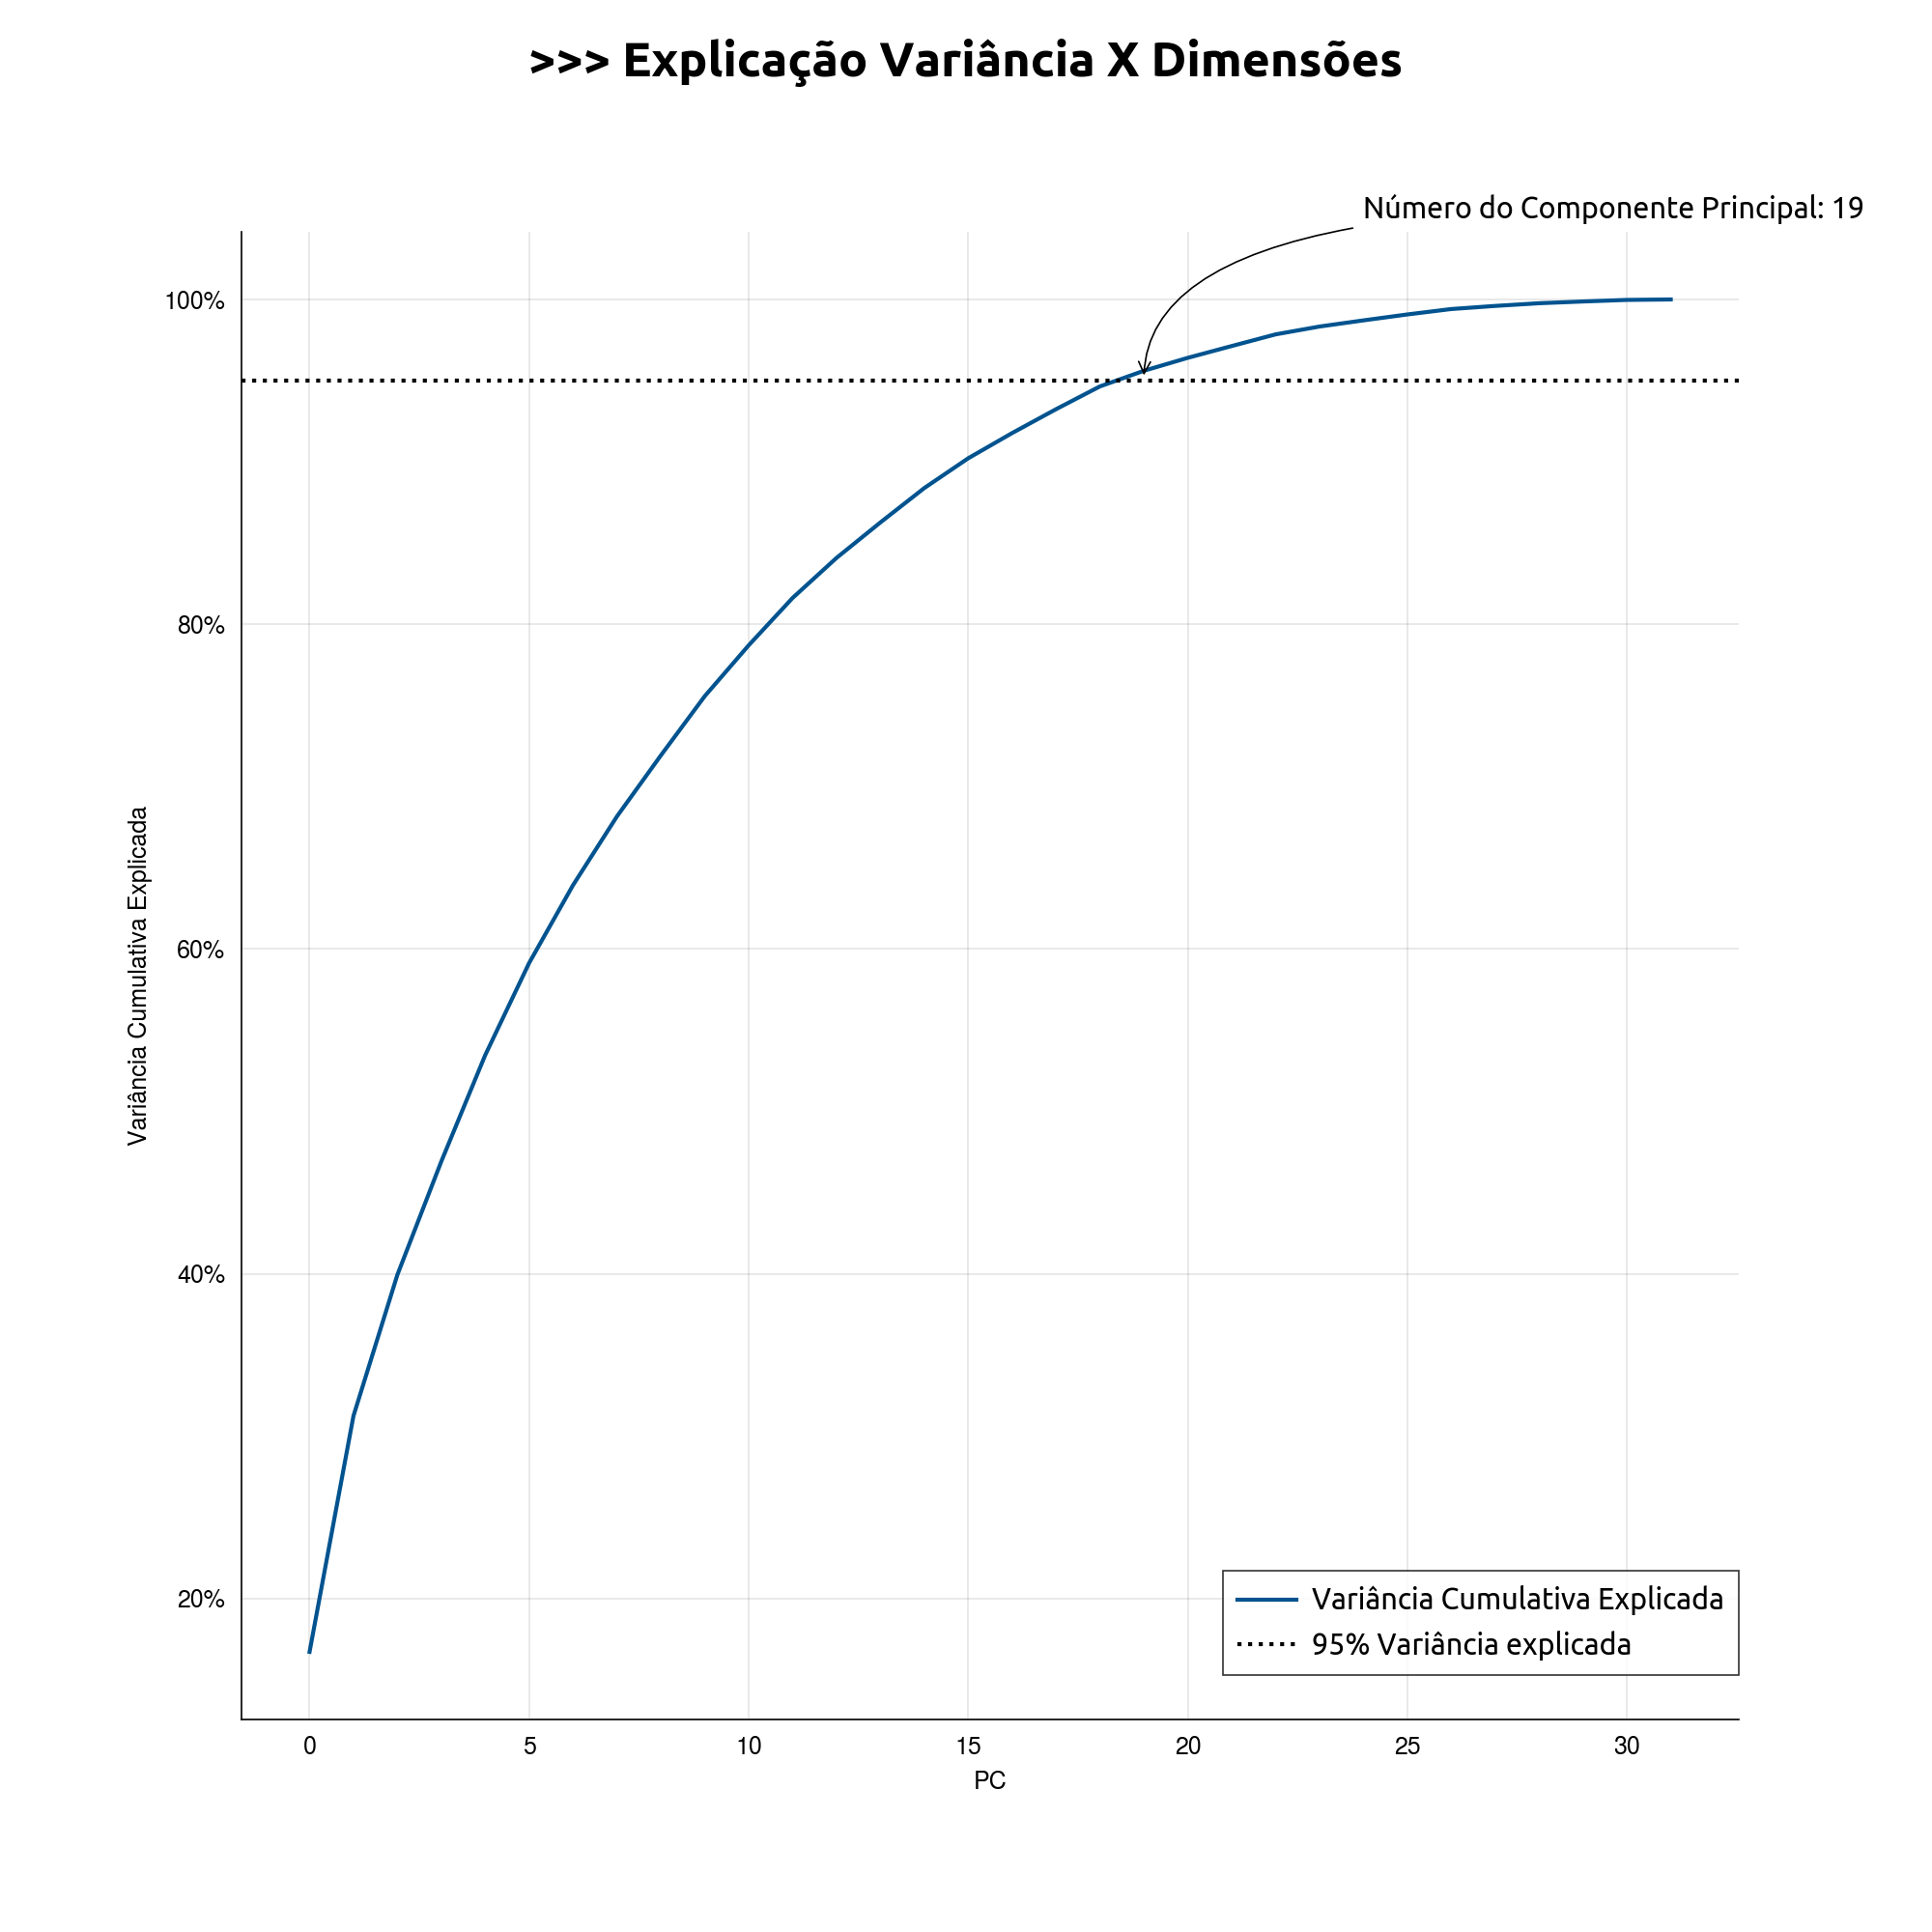

In [14]:
pca = PCA()
pca.fit(X_smote)

cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
d = [n for n in range(len(cumsum))]

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor("white")
mpl.rcParams["font.family"] = "Ubuntu"
mpl.rcParams["font.size"] = 11

ax.plot(d, cumsum, color="#00538F", label="Variância Cumulativa Explicada")

ax.axhline(y=95, color="black", linestyle=":", label="95% Variância explicada")
ax.legend(loc="best")

ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")

for i in ["top", "right"]:
    ax.spines[i].set_visible(False)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

arrowprops = dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90")
plt.annotate(
    "Número do Componente Principal: 19",
    xy=(19, 95),
    xytext=(19 + 5, 95 + 10),
    arrowprops=arrowprops,
    size=11,
)

plt.legend(bbox_to_anchor=(1, 0.1))

plt.suptitle(">>> Explicação Variância X Dimensões", size=18)
plt.ylabel("Variância Cumulativa Explicada")
plt.xlabel("PC")

In [15]:
pca = PCA(0.95)
pca.fit(X_smote)

X_pca = pca.transform(X_smote)
X_pca = pd.DataFrame(X_pca)

print(
    f""">>> Shape Antes X Depois PCA: {X_smote.shape}
>>> Shape Antes X Depois PCA: {X_pca.shape}"""
)

>>> Shape Antes X Depois PCA: (17000, 32)
>>> Shape Antes X Depois PCA: (17000, 20)


# 5. Clustering

Após aplicado o método PCA, as observações são agrupadas em diferentes grupos. Esse processo é conhecido como clustering. Existem diversos métodos de clustering, mas neste caso, será utilizada o K-Means e Hierarchical Clustering.

Essa etapa envolve agrupar os dados em conjuntos distintos com base em alguma medida de similaridade entre as observações.

## 5.1 K-Means

In [16]:
data = pd.concat([y_smote, X_pca], axis=1)

print(">>> Dados capturados e unificados com sucesso.")

>>> Dados capturados e unificados com sucesso.


In [17]:
km_list = list()

for i in range(1, 21):
    km = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=42
    )
    km = km.fit(X_pca)

    km_list.append(pd.Series({"clusters": i, "inertia": km.inertia_, "model": km}))
    
print(">>> Função KMeans aplicada com sucesso.")

>>> Função KMeans aplicada com sucesso.


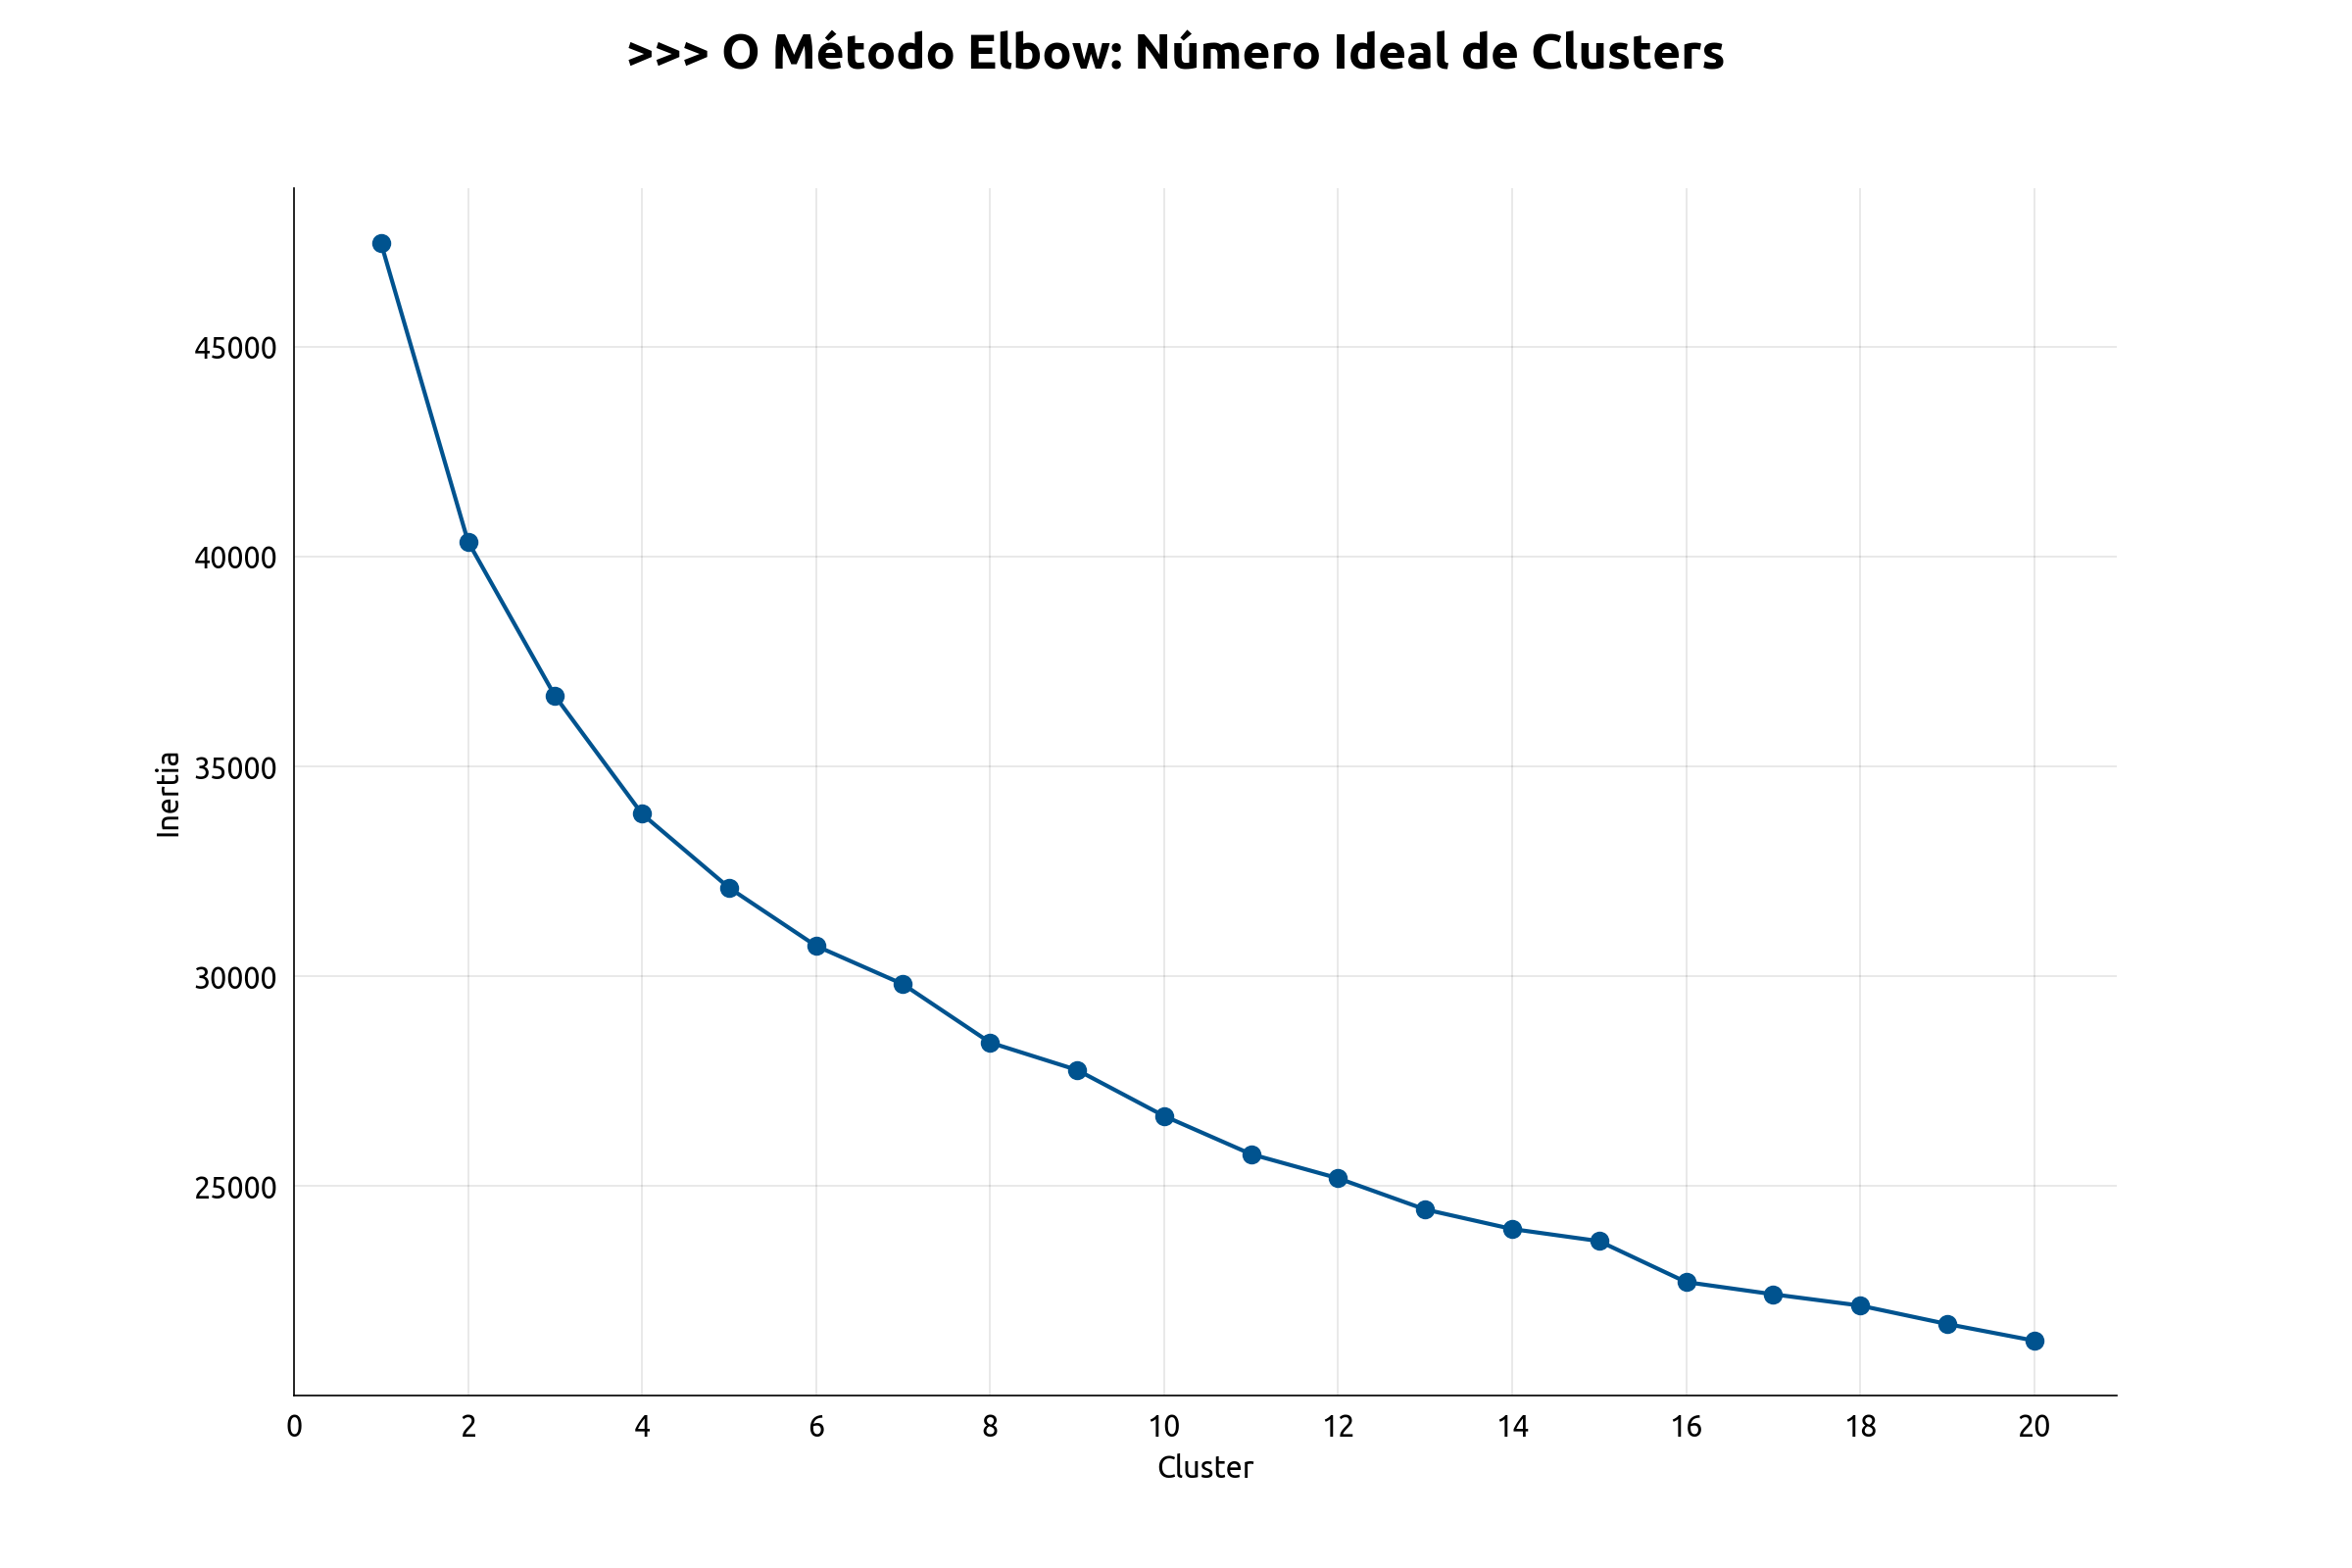

In [18]:
k = pd.concat(km_list, axis=1).T[['clusters','inertia']]

fig, ax = plt.subplots(figsize =(12, 8))
fig.patch.set_facecolor('white')
mpl.rcParams['font.size'] = 10

plt.plot(k['clusters'], k['inertia'], 'bo-', color = '#00538F')

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for i in ['top','right']:
    ax.spines[i].set_visible(False)

ax.set_xticks(range(0,21,2))
ax.set(xlabel='Cluster', ylabel='Inertia');

plt.suptitle('>>> O Método Elbow: Número Ideal de Clusters', size=18);


O método do cotovelo permitiu determinar o número ideal de clusters. Neste caso, embora fosse ideal ter de 4 a 8 clusters, eles foram mantidos em dois clusters para corresponder ao mesmo número de classes que estavam sendo previstas: churn ou não churn.

In [19]:
km = KMeans(n_clusters=3, random_state=42)
km = km.fit(X_pca)

data_kmeans = data.copy()

data_kmeans['kmeans'] = km.predict(X_pca)

print(">>> Dados clusterizados com sucesso.")

>>> Dados clusterizados com sucesso.


## 5.2 Hierarchical Clustering

In [20]:
ag = AgglomerativeClustering(n_clusters=3, linkage="complete", compute_full_tree=True)
ag = ag.fit(X_pca)

data_agglom = data.copy()

data_agglom["agglom"] = ag.fit_predict(X_pca)

print(">>> Dados clusterizados hierarquicamente agrupados com sucesso.")

>>> Dados clusterizados hierarquicamente agrupados com sucesso.


# 6. Modelagem com Gradient Boosting

## 6.1 Modelo Básico (sem usar nenhum Cluster)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_smote, test_size=0.3, random_state=42
)

In [22]:
param_grid = {
    "learning_rate": [0.1, 0.125, 0.5],
    "n_estimators": [300, 400, 500],
    "max_depth": [7, 9, 11],
}

GV_GBC = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    verbose=0,
    n_jobs=-1,
)

GV_GBC = GV_GBC.fit(X_train, y_train)

print("best score: ", GV_GBC.best_score_)
print("best param: ", GV_GBC.best_params_)

best score:  0.9183658709711341
best param:  {'learning_rate': 0.5, 'max_depth': 11, 'n_estimators': 400}


In [23]:
best_params = GV_GBC.best_params_
GB = GradientBoostingClassifier(random_state=42, **best_params)

GB = GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

print("Accuracy score: ", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score: ", round(f1_score(y_test, y_pred), 4))

Accuracy score:  0.9392
F1 Score:  0.9401


## 6.2 K-Means + Model

In [24]:
X_kmeans = data_kmeans.drop("Attrition_Flag", axis=1)
y_kmeans = data_kmeans["Attrition_Flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X_kmeans, y_kmeans, test_size=0.3, random_state=42
)

print(">>> Dados de teste agrupados com sucesso.")

>>> Dados de teste agrupados com sucesso.


In [25]:
best_params = GV_GBC.best_params_
GB = GradientBoostingClassifier(random_state=42, **best_params)

GB = GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

print("Accuracy score: ", round(accuracy_score(y_test, y_pred), 4))
print("F1 Score: ", round(f1_score(y_test, y_pred), 4))

Accuracy score:  0.9386
F1 Score:  0.9396


## 6.3 Hierarchical Clustering + Model

In [26]:
X_agglom = data_agglom.drop("Attrition_Flag", axis=1)
y_agglom = data_agglom["Attrition_Flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X_agglom, y_agglom, test_size=0.3, random_state=42
)

In [27]:
best_params = GV_GBC.best_params_
GB = GradientBoostingClassifier(random_state=42, **best_params)
                            
GB = GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_pred), 4))

Accuracy score:  0.9408
F1 Score:  0.9416


## 7. Experimentation

Nesta seção, a previsão foi realizada em conjuntos de dados separados, onde um deles continha todas as observações dentro do primeiro cluster e o outro dentro do segundo cluster.

## 7.1 Cluster = 0

In [28]:
data_kmeans0 = data_kmeans.loc[data_kmeans['kmeans'] == 0]

X_kmeans = data_kmeans0.drop('Attrition_Flag', axis=1)
y_kmeans = data_kmeans0['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X_kmeans, y_kmeans, test_size=0.3, random_state=42)

In [29]:
best_params = GV_GBC.best_params_
GB = GradientBoostingClassifier(random_state=42, **best_params)
                            
GB = GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_pred), 4))

Accuracy score:  0.9451
F1 Score:  0.9478


## 7.2 Cluster = 1

In [30]:
data_kmeans1 = data_kmeans.loc[data_kmeans["kmeans"] == 1]

X_kmeans = data_kmeans1.drop("Attrition_Flag", axis=1)
y_kmeans = data_kmeans1["Attrition_Flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X_kmeans, y_kmeans, test_size=0.3, random_state=42
)

In [31]:
best_params = GV_GBC.best_params_
GB = GradientBoostingClassifier(random_state=42, **best_params)
                            
GB = GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_pred), 4))

Accuracy score:  0.9121
F1 Score:  0.9055


## 7.3 Cluster = 2

In [32]:
data_kmeans2 = data_kmeans.loc[data_kmeans["kmeans"] == 2]

X_kmeans = data_kmeans2.drop("Attrition_Flag", axis=1)
y_kmeans = data_kmeans2["Attrition_Flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X_kmeans, y_kmeans, test_size=0.3, random_state=42
)

In [33]:
best_params = GV_GBC.best_params_
GB = GradientBoostingClassifier(random_state=42, **best_params)
                            
GB = GB.fit(X_train, y_train)
y_pred = GB.predict(X_test)

print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_pred), 4))

Accuracy score:  0.9275
F1 Score:  0.9281


### <center><b>Esta é a melhor previsão até agora!</b></center>

# 8. Conclusão

### Cluster 0

- Clientes mais velhos
- Relação bancária mais longa
- Predominantemente do sexo feminino
- Limite de crédito mais baixo
- Taxa de utilização do cartão de crédito mais alta
- Saldo rotativo mais alto no cartão de crédito

### Cluster 1

- Clientes de idade intermediária
- Duração relativamente longa do relacionamento
- Predominantemente do sexo masculino
- Limite de crédito mais alto
- Taxa de utilização do cartão de crédito mais baixa
- Saldo rotativo mais baixo no cartão de crédito

### Cluster 2 -> Cluster com previsão mais Apurada

- Clientes mais jovens
- Relação bancária mais recente
- Ligeira predominância feminina
- Limite de crédito mais baixo
- Taxa de utilização do cartão de crédito mais alta
- Saldo rotativo mais alto no cartão de crédito

<br>

### Outras Considerações

Ao analisar os dados demográficos de cada grupo, também foram observados os seguintes pontos:

- Os usuários de longa data são mais propensos a deixar o banco.
- A maioria dos clientes tem entre 40 e 50 anos.
- Os clientes com limites mais altos são predominantemente do sexo masculino.
- A proporção de clientes casados é maior entre os usuários de longa data.
- Os clientes com limites mais altos têm uma renda significativamente maior do que outros grupos e são mais propensos a possuir cartões premium.
